In [1]:
import sys
sys.path.append('../RecSysRep/')

In [2]:
import Basics.Load as ld

URM_all, _, _, ICM_channel, _ = ld.getCOOs()
ICM_weighted_3 = ld.getICMselected('3')
ICM_weighted_7 = ld.getICMselected('7')
ICM_weighted_9 = ld.getICMselected('9')
ICM_weighted_all = ld.getICMselected('all')

In [3]:
from Evaluation.Evaluator import EvaluatorHoldout
from Data_manager.split_functions.split_train_validation_random_holdout import split_train_in_two_percentage_global_sample

URM_train, URM_validation = split_train_in_two_percentage_global_sample(URM_all, train_percentage = 0.8, seed=1999)
# URM_train, URM_validation = split_train_in_two_percentage_global_sample(URM_train_validation, train_percentage = 0.8)

evaluator_validation = EvaluatorHoldout(URM_validation, cutoff_list=[10])
# evaluator_test = EvaluatorHoldout(URM_test, cutoff_list=[10])

EvaluatorHoldout: Ignoring 13646 ( 0.0%) Users that have less than 1 test interactions


In [27]:
import os

ofp = "../models_temp/Similarity_Hybrid/"

models_to_combine_best = {
                            'RP3ICMnew': {'alpha': 1.029719677583138, 'beta': 1.0630164752134375, 'topK': 6964, 'normalize_similarity': True},
                            'RP3ICM' : {"topK": 2550, "alpha": 1.3058102610510849, "beta": 0.5150718337969987, "normalize_similarity": True, "implicit": True},
                            'IALS' : {"num_factors": 29, "epochs": 50, "confidence_scaling": "log", "alpha": 0.001, "epsilon": 0.001, "reg": 0.01},
                            'SLIMgensub': {"l1_ratio" : 0.025887359156206147, "topK": 2140, "alpha": 0.009567288586539689, "workers": 8, "mw": 1},
                            'SLIMBPR' : {"epochs": 440, "lambda_i": 0.007773815998802306, "lambda_j": 0.003342522366982381, "learning_rate": 0.010055161410725193, "topK": 4289, "random_seed": 1234, "sgd_mode": "sgd"},
                            'SLIMweig': {'l1_ratio': 0.0005247075138160404, 'topK': 4983, 'alpha': 0.06067400905430761, 'workers': 8, 'mw': 2.308619939318322},
                            'SLIMER': {'topK': 6000, 'l1_ratio': 0.0005495104968035837, 'alpha': 0.08007142704041009, 'workers': 8},
                            'P3alpha': {'topK': 4834, 'alpha': 1.764994849187595, 'normalize_similarity': True, 'implicit': True},
                            'RP3beta': {"topK": 1049, "alpha": 1.1626473723475605, "beta": 0.6765017195261293, "normalize_similarity": True, "implicit": True},
                            'icm_7': {"shrink": 4000, "topK": 985, "feature_weighting": "TF-IDF", "normalize": True},
                            'icm_3': {'shrink': 2211, 'topK': 188, 'feature_weighting': 'TF-IDF', 'normalize': True},
                            'icm_9': {'shrink': 3568, 'topK': 986, 'feature_weighting': 'TF-IDF', 'normalize': True},
                            'icm_all': {"shrink": 5212, "topK": 923, "feature_weighting": "TF-IDF", "normalize": True},
                            'icm_channel': {"shrink": 2000, "topK": 382, "feature_weighting": "TF-IDF", "normalize": False},
                            'UserKNN' : {'topK': 448, 'similarity': 'cosine', 'shrink': 756, 'normalize': True, 'feature_weighting': 'TF-IDF', 'URM_bias': True},
                         }


In [5]:
def model_init(recommender, name, args):
    path_name = ofp + name + ".zip"
    print(path_name)
    if os.path.exists(path_name):
        print("Model found!")
        recommender.load_model(ofp, name)
    else:
        print("Model does not exists, creating...")
        if not os.path.exists(ofp):
            print("Main folder does not exist, creating...")
            os.makedirs(ofp)
        recommender.fit(**args)
        recommender.save_model(ofp, name)

In [6]:
from Recommenders.NonPersonalizedRecommender import TopPop
from Recommenders.KNN.ItemKNNCBFRecommender import ItemKNNCBFRecommender
from Recommenders.SLIM.Cython.SLIM_BPR_Cython import SLIM_BPR_Cython
from Recommenders.SLIM.SLIMElasticNetRecommender import MultiThreadSLIM_SLIMElasticNetRecommender
from Recommenders.GraphBased.P3alphaRecommender import P3alphaRecommender
from Recommenders.GraphBased.RP3betaRecommender import RP3betaRecommender
from Recommenders.GraphBased.RP3betaRecommender import RP3betaRecommenderICM
from Recommenders.MatrixFactorization.IALSRecommender import IALSRecommender

In [7]:
from Recommenders.KNN.ItemKNNSimilarityHybridRecommender import ItemKNNSimilarityHybridRecommender
from Recommenders.KNN.ItemKNNSimilarityHybridRecommenderNormal import ItemKNNSimilarityHybridRecommenderNormal

In [51]:
recommender1 = MultiThreadSLIM_SLIMElasticNetRecommender(URM_train)
recommender2 = ItemKNNCBFRecommender(URM_train, ICM_weighted_3)
recommender3 = ItemKNNCBFRecommender(URM_train, ICM_weighted_7)
recommender4 = ItemKNNCBFRecommender(URM_train, ICM_weighted_9)
recommender5 = ItemKNNCBFRecommender(URM_train, ICM_weighted_all)
recommender6 = ItemKNNCBFRecommender(URM_train, ICM_channel)

recommender2.RECOMMENDER_NAME = "ICM_3"
recommender3.RECOMMENDER_NAME = "ICM_7"
recommender4.RECOMMENDER_NAME = "ICM_9"
recommender5.RECOMMENDER_NAME = "ICM_all"
recommender6.RECOMMENDER_NAME = "ICM_channel"

model_init(recommender1, 'SLIM_pure', models_to_combine_best['SLIMER'])
model_init(recommender2, 'KNNweigh3', models_to_combine_best['icm_3'])
model_init(recommender3, 'KNNweigh7', models_to_combine_best['icm_7'])
model_init(recommender4, 'KNNweigh9', models_to_combine_best['icm_9'])
model_init(recommender5, 'KNNweigh10', models_to_combine_best['icm_all'])
model_init(recommender6, 'KNNchannel', models_to_combine_best['icm_channel'])

ItemKNNCBFRecommender: ICM Detected 9654 (53.5%) items with no features.
ItemKNNCBFRecommender: ICM Detected 22 ( 0.1%) items with no features.
ItemKNNCBFRecommender: ICM Detected 1 ( 0.0%) items with no features.
ItemKNNCBFRecommender: ICM Detected 352 ( 1.9%) items with no features.
../models_temp/Similarity_Hybrid/SLIM_pure.zip
Model found!
SLIMElasticNetRecommender: Loading model from file '../models_temp/Similarity_Hybrid/SLIM_pure'
SLIMElasticNetRecommender: Loading complete
../models_temp/Similarity_Hybrid/KNNweigh3.zip
Model found!
ICM_3: Loading model from file '../models_temp/Similarity_Hybrid/KNNweigh3'
ICM_3: Loading complete
../models_temp/Similarity_Hybrid/KNNweigh7.zip
Model found!
ICM_7: Loading model from file '../models_temp/Similarity_Hybrid/KNNweigh7'
ICM_7: Loading complete
../models_temp/Similarity_Hybrid/KNNweigh9.zip
Model found!
ICM_9: Loading model from file '../models_temp/Similarity_Hybrid/KNNweigh9'
ICM_9: Loading complete
../models_temp/Similarity_Hybrid/K

In [96]:
def rank_models(evaluator, recommenders):
    for r in recommenders:
        r_d, _ = evaluator.evaluateRecommender(r)
        iw = r._compute_item_score([1,2,3,4], [1,2])
        print(r.RECOMMENDER_NAME, r_d.loc[10]['MAP'])
        print(r.RECOMMENDER_NAME, iw)

In [53]:
rank_models(evaluator_validation, [recommender1, recommender2, recommender3, recommender4, recommender5, recommender6])

EvaluatorHoldout: Processed 13646 (100.0%) in 15.44 sec. Users per second: 884
SLIMElasticNetRecommender 0.24746682846767187
EvaluatorHoldout: Processed 13646 (100.0%) in 6.52 sec. Users per second: 2092
ICM_3 0.08461506249869005


KeyboardInterrupt: 

In [13]:
import matplotlib.pyplot as plt

In [54]:
import numpy as np

def test_percentage(recommender_1, recommender_2, evaluator, high, low, step):
    recommender = ItemKNNSimilarityHybridRecommenderNormal(URM_train, recommender_1.W_sparse, recommender_2.W_sparse)
    results = []
    alp_space = np.linspace(high, low, step, True)
    for alp in alp_space:
        recommender.fit(alp)
        r_d, _ = evaluator.evaluateRecommender(recommender)
        print(alp, ":", r_d.loc[10]['MAP'])
        results.append(r_d.loc[10]['MAP'])
    
    return alp_space, results

EvaluatorHoldout: Processed 13646 (100.0%) in 21.31 sec. Users per second: 640
0.92 : 0.24791937982873158
EvaluatorHoldout: Processed 13646 (100.0%) in 20.48 sec. Users per second: 666
0.9210344827586208 : 0.24792477707288035
EvaluatorHoldout: Processed 13646 (100.0%) in 19.60 sec. Users per second: 696
0.9220689655172414 : 0.24791126069852576
EvaluatorHoldout: Processed 13646 (100.0%) in 19.65 sec. Users per second: 694
0.9231034482758621 : 0.24789946295094475
EvaluatorHoldout: Processed 13646 (100.0%) in 19.82 sec. Users per second: 689
0.9241379310344828 : 0.247857960004561
EvaluatorHoldout: Processed 13646 (100.0%) in 19.51 sec. Users per second: 699
0.9251724137931034 : 0.24785738131297405
Deallocating Cython objects
EvaluatorHoldout: Processed 13646 (100.0%) in 20.25 sec. Users per second: 674
0.9262068965517242 : 0.24783505952090287
EvaluatorHoldout: Processed 13646 (100.0%) in 19.43 sec. Users per second: 702
0.9272413793103449 : 0.2478159626985304
EvaluatorHoldout: Processed 1

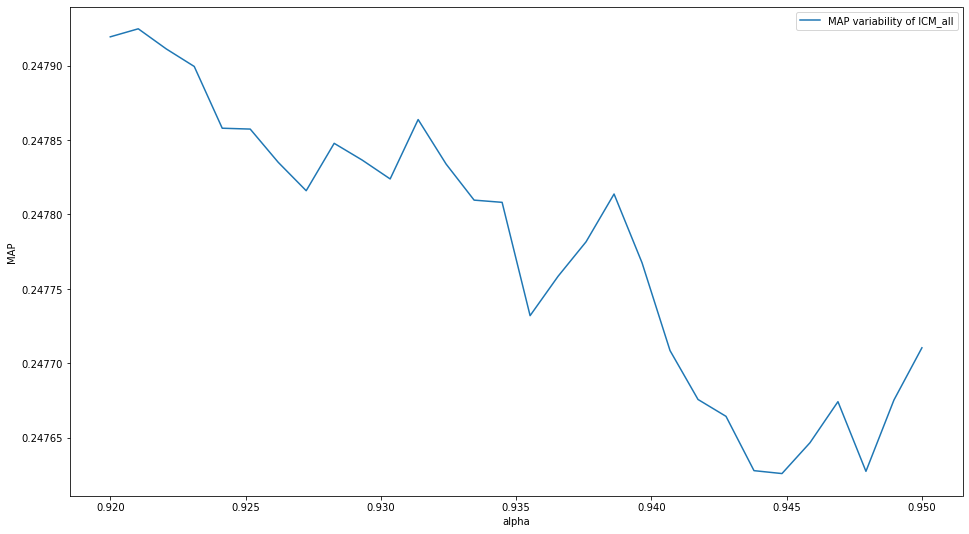

In [57]:
alp_spaces = []

import matplotlib.pyplot as plt
_ = plt.figure(figsize=(16, 9))

alp_space, results = test_percentage(recommender1, recommender3, evaluator_validation, 0.92, 0.95, 30)
plt.plot(alp_space, results, label='MAP variability of ' + r.RECOMMENDER_NAME)
plt.ylabel('MAP')
plt.xlabel('alpha')
plt.legend()
plt.show()

In [68]:
best_alpha = 0.9210344

In [69]:
recommender = ItemKNNSimilarityHybridRecommenderNormal(URM_train, recommender1.W_sparse, recommender3.W_sparse)
recommender.fit(best_alpha)

In [86]:
def test_percentage(recommender_a, recommender_b, evaluator, high1, low1, step):
    recommender = TwoDifferentModelRecommender(URM_train, recommender_a, recommender_b)
    results = []
    alp_space = np.linspace(high1, low1, step, True)
    for alp in alp_space:
        recommender.fit(2, alp)
        r_d, _ = evaluator.evaluateRecommender(recommender)
        print(alp, ":", r_d.loc[10]['MAP'])
        results.append(r_d.loc[10]['MAP'])
    
    return alp_space, results

In [61]:
from Recommenders.KNN.ItemKNNSimilarityHybridRecommender import ItemKNNSimilarityHybridRecommender
from Recommenders.KNN.ItemKNNSimilarityHybridRecommenderNormal import ItemKNNSimilarityHybridRecommenderNormal
from Recommenders.KNN.ItemKNNScoresHybridMultipleRecommender import ItemKNNScoresHybridMultipleRecommender
from Recommenders.HybridScores.DifferentStructure import TwoDifferentModelRecommender

In [62]:
recommender11 = SLIM_BPR_Cython(URM_train)

model_init(recommender11, 'SLIM_BPRd', models_to_combine_best['SLIMBPR'])

../models_temp/Similarity_Hybrid/SLIM_BPRd.zip
Model found!
SLIM_BPR_Recommender: Loading model from file '../models_temp/Similarity_Hybrid/SLIM_BPRd'
SLIM_BPR_Recommender: Loading complete


In [71]:
rank_models(evaluator_validation, [recommender, recommender11])

EvaluatorHoldout: Processed 13646 (100.0%) in 19.15 sec. Users per second: 713
ItemKNNSimilarityHybridRecommender 0.24792477707288035
EvaluatorHoldout: Processed 13646 (100.0%) in 30.81 sec. Users per second: 443
SLIM_BPR_Recommender 0.23027203738987354


In [72]:
import numpy as np

def test_percentage(recommender_1, recommender_2, evaluator, high, low, step):
    recommender = ItemKNNSimilarityHybridRecommenderNormal(URM_train, recommender_1.W_sparse, recommender_2.W_sparse)
    results = []
    alp_space = np.linspace(high, low, step, True)
    for alp in alp_space:
        recommender.fit(alp)
        r_d, _ = evaluator.evaluateRecommender(recommender)
        print(alp, ":", r_d.loc[10]['MAP'])
        results.append(r_d.loc[10]['MAP'])
    
    return alp_space, results

EvaluatorHoldout: Processed 13646 (100.0%) in 33.82 sec. Users per second: 404
0.988534 : 0.2497703466798805
EvaluatorHoldout: Processed 13646 (100.0%) in 33.74 sec. Users per second: 404
0.9885373157894737 : 0.24975773469288035
EvaluatorHoldout: Processed 13646 (100.0%) in 33.42 sec. Users per second: 408
0.9885406315789473 : 0.24975519601069196
EvaluatorHoldout: Processed 13646 (100.0%) in 33.44 sec. Users per second: 408
0.9885439473684211 : 0.24975457951513194
EvaluatorHoldout: Processed 13646 (100.0%) in 33.80 sec. Users per second: 404
0.9885472631578948 : 0.24975186635306806
EvaluatorHoldout: Processed 13646 (100.0%) in 33.42 sec. Users per second: 408
0.9885505789473684 : 0.24975755730500696
EvaluatorHoldout: Processed 13646 (100.0%) in 33.50 sec. Users per second: 407
0.9885538947368421 : 0.2497658625470803
EvaluatorHoldout: Processed 13646 (100.0%) in 33.58 sec. Users per second: 406
0.9885572105263157 : 0.24976735435001574
EvaluatorHoldout: Processed 13646 (100.0%) in 33.76 

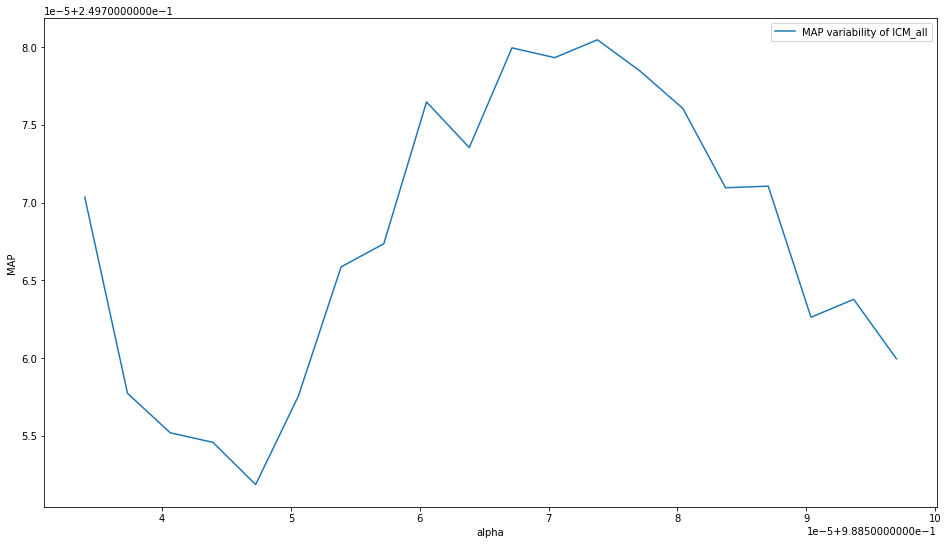

In [78]:
alp_space, results = test_percentage(recommender, recommender11, evaluator_validation, 0.988534, 0.988597 , 20)

import matplotlib.pyplot as plt
_ = plt.figure(figsize=(16, 9))
plt.plot(alp_space, results, label='MAP variability of ' + r.RECOMMENDER_NAME)
plt.ylabel('MAP')
plt.xlabel('alpha')
plt.legend()
plt.show()

In [79]:
recommenderr = ItemKNNSimilarityHybridRecommenderNormal(URM_train, recommender.W_sparse, recommender11.W_sparse)
recommenderr.fit(0.98857378)

In [90]:
from Recommenders.KNN.UserKNNCFRecommender import UserKNNCFRecommender

recommender2 = RP3betaRecommender(URM_train)

model_init(recommender2, 'RP3B', models_to_combine_best['RP3beta'])

../models_temp/Similarity_Hybrid/RP3B.zip
Model does not exists, creating...
RP3betaRecommender: Saving model in file '../models_temp/Similarity_Hybrid/RP3B'
RP3betaRecommender: Saving complete


In [97]:
rank_models(evaluator_validation, [recommenderr, recommender2])

EvaluatorHoldout: Processed 13646 (100.0%) in 49.75 sec. Users per second: 274
ItemKNNSimilarityHybridRecommender 0.24978046942065676
ItemKNNSimilarityHybridRecommender [[      -inf 0.04656392 0.03055764 ...       -inf       -inf       -inf]
 [      -inf 0.01859655 0.00175326 ...       -inf       -inf       -inf]
 [      -inf 0.00323506 0.0021748  ...       -inf       -inf       -inf]
 [      -inf 0.05146625 0.01347951 ...       -inf       -inf       -inf]]
EvaluatorHoldout: Processed 13646 (100.0%) in 20.38 sec. Users per second: 670
RP3betaRecommender 0.21860218646548016
RP3betaRecommender [[      -inf 0.00278259 0.00612615 ...       -inf       -inf       -inf]
 [      -inf 0.00084296 0.         ...       -inf       -inf       -inf]
 [      -inf 0.         0.         ...       -inf       -inf       -inf]
 [      -inf 0.00235235 0.         ...       -inf       -inf       -inf]]


In [93]:
alp_space, results = test_percentage(recommenderr, recommender2, evaluator_validation, 0.95, 1, 20)

import matplotlib.pyplot as plt
_ = plt.figure(figsize=(16, 9))
plt.plot(alp_space, results, label='MAP variability of ' + r.RECOMMENDER_NAME)
plt.ylabel('MAP')
plt.xlabel('alpha')
plt.legend()
plt.show()

EvaluatorHoldout: Processed 13646 (100.0%) in 4.50 min. Users per second: 50
0.95 : 0.24935413366088954
EvaluatorHoldout: Processed 13646 (100.0%) in 4.60 min. Users per second: 49
0.9526315789473684 : 0.2493828152444224
EvaluatorHoldout: Processed 13646 (100.0%) in 4.97 min. Users per second: 46
0.9552631578947368 : 0.24940619554773819
EvaluatorHoldout: Processed 12000 (87.9%) in 5.10 min. Users per second: 39
EvaluatorHoldout: Processed 13646 (100.0%) in 5.60 min. Users per second: 41
0.9578947368421052 : 0.2494283806639068
EvaluatorHoldout: Processed 13000 (95.3%) in 5.30 min. Users per second: 41
EvaluatorHoldout: Processed 13646 (100.0%) in 5.37 min. Users per second: 42
0.9605263157894737 : 0.24943531042296171
EvaluatorHoldout: Processed 13646 (100.0%) in 4.80 min. Users per second: 47
0.9631578947368421 : 0.24941662944429233
EvaluatorHoldout: Processed 13646 (100.0%) in 4.82 min. Users per second: 47
0.9657894736842105 : 0.24943274266079377


KeyboardInterrupt: 

EvaluatorHoldout: Processed 12000 (87.9%) in 5.26 min. Users per second: 38
EvaluatorHoldout: Processed 13646 (100.0%) in 5.80 min. Users per second: 39
0.997 : 0.24969731231199738
EvaluatorHoldout: Processed 11000 (80.6%) in 5.23 min. Users per second: 35
EvaluatorHoldout: Processed 13646 (100.0%) in 6.40 min. Users per second: 36
0.9971578947368421 : 0.24970071466956953
EvaluatorHoldout: Processed 11000 (80.6%) in 5.32 min. Users per second: 34
EvaluatorHoldout: Processed 13646 (100.0%) in 6.31 min. Users per second: 36
0.9973157894736842 : 0.24971921826036533
EvaluatorHoldout: Processed 12000 (87.9%) in 5.09 min. Users per second: 39
EvaluatorHoldout: Processed 13646 (100.0%) in 5.55 min. Users per second: 41
0.9974736842105263 : 0.24971993071985701
EvaluatorHoldout: Processed 13646 (100.0%) in 5.01 min. Users per second: 45
0.9976315789473684 : 0.24972653187514643
EvaluatorHoldout: Processed 13646 (100.0%) in 4.95 min. Users per second: 46
0.9977894736842106 : 0.2497227223978649
Ev

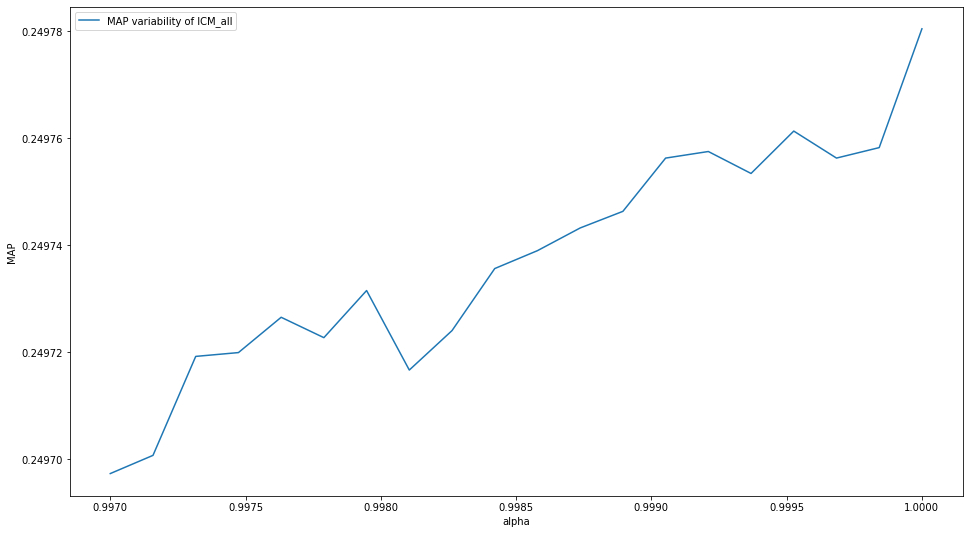

In [98]:
alp_space, results = test_percentage(recommenderr, recommender2, evaluator_validation, 0.997, 1, 20)

import matplotlib.pyplot as plt
_ = plt.figure(figsize=(16, 9))
plt.plot(alp_space, results, label='MAP variability of ' + r.RECOMMENDER_NAME)
plt.ylabel('MAP')
plt.xlabel('alpha')
plt.legend()
plt.show()

In [99]:
from Recommenders.KNN.UserKNNCFRecommender import UserKNNCFRecommender

recommender2 = IALSRecommender(URM_train)

model_init(recommender2, 'IALSn', models_to_combine_best['IALS'])

../models_temp/Similarity_Hybrid/IALSn.zip
Model found!
IALSRecommender: Loading model from file '../models_temp/Similarity_Hybrid/IALSn'
IALSRecommender: Loading complete


EvaluatorHoldout: Processed 13646 (100.0%) in 4.65 min. Users per second: 49
0.7 : 0.2452404681644027
EvaluatorHoldout: Processed 4000 (29.3%) in 5.17 min. Users per second: 13
EvaluatorHoldout: Processed 9000 (66.0%) in 10.89 min. Users per second: 14
EvaluatorHoldout: Processed 13000 (95.3%) in 17.36 min. Users per second: 12
EvaluatorHoldout: Processed 13646 (100.0%) in 17.48 min. Users per second: 13
0.703030303030303 : 0.2452863301996754
EvaluatorHoldout: Processed 13646 (100.0%) in 4.46 min. Users per second: 51
0.706060606060606 : 0.24536769016561705
EvaluatorHoldout: Processed 13646 (100.0%) in 3.53 min. Users per second: 64
0.709090909090909 : 0.24543906988268085
EvaluatorHoldout: Processed 13646 (100.0%) in 3.53 min. Users per second: 64
0.712121212121212 : 0.24553307382360004
EvaluatorHoldout: Processed 13646 (100.0%) in 3.53 min. Users per second: 64
0.7151515151515151 : 0.24554683737777852
EvaluatorHoldout: Processed 13646 (100.0%) in 3.53 min. Users per second: 64
0.71818

0.906060606060606 : 0.24876180647157448
EvaluatorHoldout: Processed 13646 (100.0%) in 3.51 min. Users per second: 65
0.9090909090909091 : 0.2487333924238509
EvaluatorHoldout: Processed 13646 (100.0%) in 3.50 min. Users per second: 65
0.9121212121212121 : 0.24873317432400655
EvaluatorHoldout: Processed 13646 (100.0%) in 3.57 min. Users per second: 64
0.9151515151515152 : 0.248751145751182
EvaluatorHoldout: Processed 13646 (100.0%) in 3.54 min. Users per second: 64
0.9181818181818182 : 0.248849095845285
EvaluatorHoldout: Processed 13646 (100.0%) in 3.53 min. Users per second: 64
0.9212121212121211 : 0.2489050399093634
EvaluatorHoldout: Processed 13646 (100.0%) in 3.53 min. Users per second: 64
0.9242424242424242 : 0.24889302987793355
EvaluatorHoldout: Processed 13646 (100.0%) in 3.52 min. Users per second: 65
0.9272727272727272 : 0.2489009890682535
EvaluatorHoldout: Processed 13646 (100.0%) in 3.50 min. Users per second: 65
0.9303030303030303 : 0.24894279735441927
EvaluatorHoldout: Proce

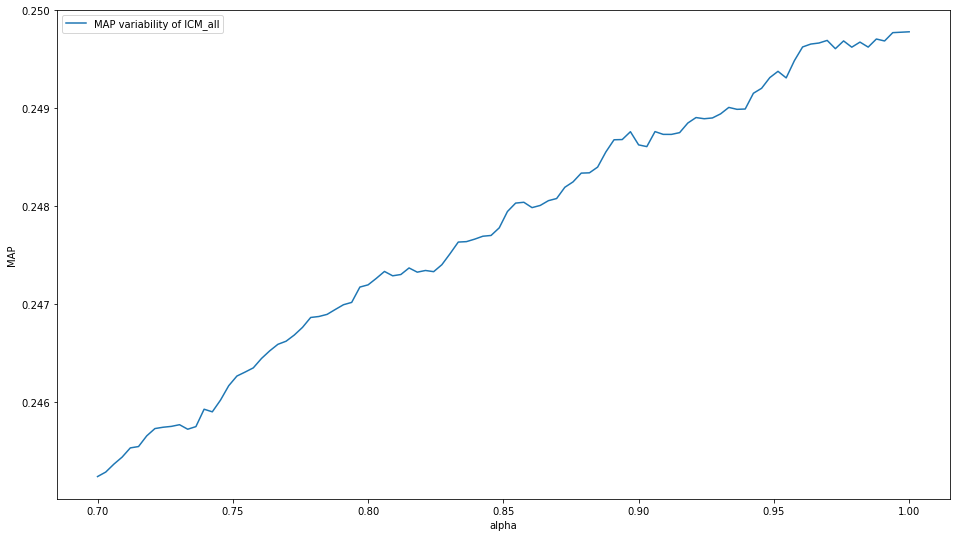

In [102]:
alp_space, results = test_percentage(recommenderr, recommender2, evaluator_validation, 0.7, 1, 100)

import matplotlib.pyplot as plt
_ = plt.figure(figsize=(16, 9))
plt.plot(alp_space, results, label='MAP variability of ' + r.RECOMMENDER_NAME)
plt.ylabel('MAP')
plt.xlabel('alpha')
plt.legend()
plt.show()